In [ ]:
import scanpy as sc

adatas = {}
for k in ['tcells.tissue.scps', 'tcells.tissue.ad']:
    adata = sc.read_h5ad(
        f'../data/{k}.integrated.clustered.h5ad'
    )
    adata.X = adata.layers['counts'].copy()
    adatas[k] = adata

adatas

In [ ]:
%matplotlib inline
from sctools import plot
import matplotlib.pyplot as plt


# only doing for AD since SCPS already done
k = 'tcells.tissue.ad'
fig, axs = plot.integrate.plot_leiden_clusterings(
    {k: adatas[k]},
    [0.6, 0.7, 0.8, 0.9],
    legend_loc = 'on data'
)
plt.show()

In [ ]:
resolutions = {
    'tcells.tissue.scps': 0.4,
    'tcells.tissue.ad': 0.7
}

# only doing for AD since SCPS already done
res = resolutions[k]
sc.tl.leiden(
    adatas[k],
    resolution = res,
    key_added = f'leiden_scvi_{res}',
)

In [ ]:
import pandas as pd


def rank_genes_group_to_data_frame(adata, rank_keys, groupby, n_genes):
    groups = adata.obs[groupby].cat.categories
    rank_results = []
    for k in rank_keys:
        rank_data = adata.uns['rank_genes_groups'][k]
        rank_results.append(
            pd.DataFrame({g: rank_data[g][:n_genes] for g in groups}).melt(value_name = k, var_name = 'group')
        )
    
    df = pd.concat(
        [rank_results[0]] + [rank_res.iloc[:, 1] for rank_res in rank_results[1:]],
        axis = 1
    )
    return df


rank_keys = ['names', 'scores', 'logfoldchanges', 'pvals', 'pvals_adj']
n_genes = 100
for k, adata in adatas.items():
    res = resolutions[k]
    groupby = f'leiden_scvi_{res}'
    adata.X = adata.layers['counts']
    adata.layers['cpm'] = sc.pp.normalize_total(
        adata,
        target_sum = 1e4,
        inplace = False
    )['X']
    adata.layers['logcpm'] = sc.pp.log1p(
        adata.layers['cpm'],
        copy = True
    )
    sc.tl.rank_genes_groups(
        adata, 
        groupby, 
        use_raw = False,
        layer = 'logcpm',
        method = 'wilcoxon'
    )
    rank_results = rank_genes_group_to_data_frame(
        adata, 
        rank_keys, 
        groupby, 
        n_genes = n_genes
    )
    rank_results.to_csv(
        f'../markers/{k}.rank_genes_groups_{groupby}_logcpm.tsv',
        sep = '\t',
        index = False
    )

In [ ]:
import pandas as pd
genes = pd.read_csv(
    '../resource/Th2vsTh17_genes.txt',
    sep = '\t'
)
score_gene_dict = {
    k: group for k, group in genes.groupby('helper_subset')
}
score_gene_dict

In [ ]:
genes_in_data = set(adata.var.index)
for key, gene_set in score_gene_dict.items():
    gene_set = set(gene_set.gene)
    print(key, ', '.join(genes_in_data & gene_set))

In [ ]:
from sctools import score

score_frames_dict = {}
for k, adata in adatas.items():
    adata.X = adata.layers['counts']
    sc.pp.normalize_total(adata, target_sum = 1e4)
    sc.pp.log1p(adata)

    score_frames_dict[k] = {
        k: score.gene_module_score(adata, score_genes.gene)
        for k, score_genes
        in score_gene_dict.items()
    }

In [ ]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler

cluster_keys = {
    'tcells.tissue.ad': 'leiden_scvi_0.7',
    'tcells.tissue.scps': 'leiden_scvi_0.4'
}


melted_score_frames = {}
for k, score_frames in score_frames_dict.items():
    score_df = pd.DataFrame(
        score_frames
    )
    
    cluster_key = cluster_keys[k]
    score_df[cluster_key] = adata.obs[cluster_key].values
    melted_score_frames[k] = score_df.melt(
        id_vars = [cluster_key],
        value_vars = score_frames.keys()
    )

In [ ]:
def subsample_dataframe(df, groupby, n_samples_per_group):
    subsampled_frames = []
    for _, group in df.groupby(groupby):
        sample = np.random.choice(
            group.index,
            size = n_samples_per_group,
            replace = False
        )
        subsampled_frames.append(
            group.loc[sample, :]
        )
    
    return pd.concat(subsampled_frames)


sampled_score_frames = {}
for k, score_frames in score_frames_dict.items():
    score_df = pd.DataFrame(
        score_frames
    )
    
    cluster_key = cluster_keys[k]
    sampled_scores = subsample_dataframe(
        score_df,
        cluster_key,
        100
    )
    sampled_score_frames[k] = sampled_scores.melt(
        id_vars = [cluster_key],
        value_vars = score_frames.keys()
    )

In [ ]:
import matplotlib as mpl

mpl.rcParams['pdf.fonttype'] = 42


for k, score_frames in score_frames_dict.items():
    fig, ax = plt.subplots()

    palette = {
        'Th17_Th1': '#b4694b',
        'Th2': '#6cc7b3'
    }
    sns.stripplot(
        data = sampled_score_frames[k], 
        y = 'value', 
        x = cluster_key, 
        hue = 'variable',
        dodge = True, 
        alpha = .3, 
        legend = False,
        ax = ax,
        zorder = 1,
        palette = palette
    )

    marker_dodge = 0.4
    sns.pointplot(
        data = melted_score_frames[k], 
        y = 'value', 
        x = cluster_key, 
        hue = 'variable',
        estimator = 'median',
        dodge = marker_dodge, 
        linestyle = 'none', 
        errorbar = None,
        marker = '_', 
        markersize = 20, 
        markeredgewidth = 3,
        ax = ax,
        zorder = 3,
        palette = palette
    )
    
    score_df = pd.DataFrame(
        score_frames
    )
    cluster_key = cluster_keys[k]
    for i, (_, group) in enumerate(score_df.groupby(cluster_key)):
        th17_th1_mean = group['Th17_Th1'].median()
        th2_mean = group['Th2'].median()
        ax.plot(
            [i - marker_dodge / 2, i + marker_dodge / 2],
            [th17_th1_mean, th2_mean],
            c = 'darkgrey',
            zorder = 2
        )

    fig.set_figwidth(10)
    fig.set_figheight(5)
    fig.tight_layout()
    fig.savefig(f'../plots/{k}.th17_th2_scores.pdf')

In [ ]:
from sctools import plot

# only plotting for AD since we already have for SCPS
plot_dir = '../plots/'
k = 'tcells.tissue.ad'
plot.misc.generate_and_save_for_figure(
    adata,
    {
        'leiden_scvi_0.7': (None, None)
    },
    f'{plot_dir}/{k}' + '.integrated.{0}.png',
    f'{plot_dir}/{k}' + '.integrated.{0}.legend.pdf',
    size = 20,
    edgecolor = 'k',
    linewidths = 0.05
)

In [19]:
# only SCPS Tcells were annotated manually here
import pandas as pd

adata = adatas['tcells.tissue.scps']
tcelltypes = pd.read_csv(
    '../resource/tcells.tissue.scps.annotation.tsv',
    sep = '\t'
)

tcelltypes.loc[:, 'leiden_cluster'] = tcelltypes.leiden_cluster.astype(str)
cluster_tcelltype_map = tcelltypes \
    .loc[:, ['leiden_cluster', 'label', 'cell_type']] \
    .groupby('leiden_cluster') \
    .agg(lambda x: ''.join(x.unique())) 

tcell_short = cluster_tcelltype_map.loc[:, 'label'].to_dict()
tcell_long = cluster_tcelltype_map.loc[:, 'cell_type'].to_dict()
for column, mapping in zip(['t_cell_types', 't_cell_types_labels'], [tcell_long, tcell_short]):
    if not column in adata.obs.columns:
        adata.obs[column] = ''
        
    adata.obs.loc[:, column] = adata.obs.loc[:, 'leiden_scvi_0.4'].apply(
        lambda x: mapping[x]
    )

adata

/tmp/ipykernel_32522/1803859341.py:22: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  adata.obs.loc[:, column] = adata.obs.loc[:, 'leiden_scvi_0.4'].apply(
/tmp/ipykernel_32522/1803859341.py:22: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  adata.obs.loc[:, column] = adata.obs.loc[:, 'leiden_scvi_0.4'].apply(


AnnData object with n_obs × n_vars = 62432 × 20912
    obs: 'sample_id', 'patient_id', 'status', 'tissue', 'cell_fraction', 'doublet', 'doublet_score', 'nFeature_RNA', 'nCount_RNA', 'percent_mt', 'percent_ribo', 'qc_pass', '_scvi_batch', '_scvi_labels', 'leiden_scvi_0.1', 'coarse_cell_types', 'leiden_scvi_0.4', 't_cell_types', 't_cell_types_labels'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'leiden', 'neighbors', 'umap'
    obsm: 'X_scvi', 'X_umap'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

In [22]:
adata.X = adata.layers['counts'].copy()
sc.pp.normalize_total(
    adata,
    target_sum = 1e4
)
sc.pp.log1p(adata)

/users/daniel.malzl/.local/lib/python3.9/site-packages/scanpy/plotting/_anndata.py:839: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(
/users/daniel.malzl/.local/lib/python3.9/site-packages/scanpy/plotting/_anndata.py:839: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  ax = sns.violinplot(


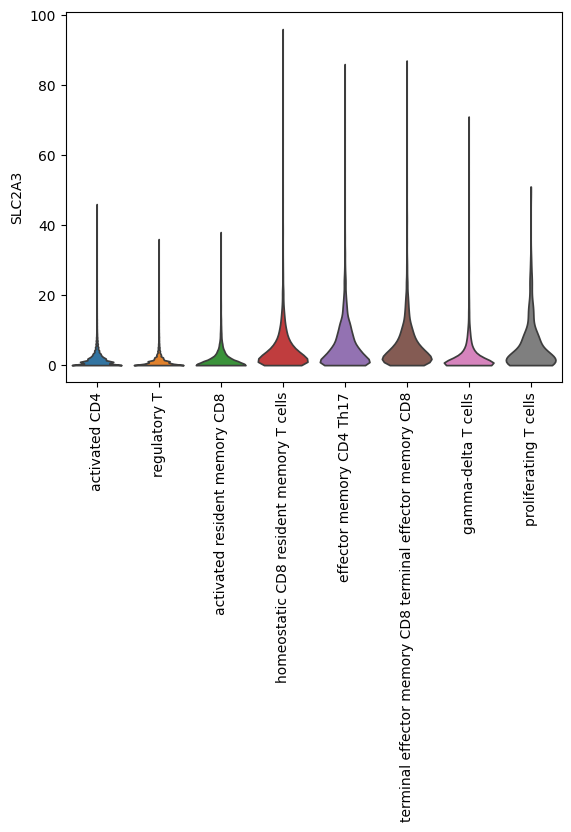

In [28]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rcParams['pdf.fonttype'] = 42

fig, ax = plt.subplots()
sc.pl.violin(
    adata,
    groupby = 't_cell_types',
    keys = ['SLC2A3'],
    stripplot = False,
    rotation = 90,
    ax = ax
)

fig.savefig('../plots/tcells.tissue.scps.slc2a3.pdf')